In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"


In [ ]:
!unzip -q converted.zip


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: BACK


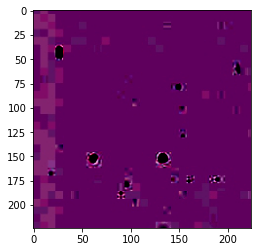

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class InceptionA(nn.Module):

    def __init__(self, input_channels, pool_features):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 64, kernel_size=1)

        self.branch5x5 = nn.Sequential(
            BasicConv2d(input_channels, 48, kernel_size=1),
            BasicConv2d(48, 64, kernel_size=5, padding=2)
        )

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, padding=1)
        )

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, pool_features, kernel_size=3, padding=1)
        )

    def forward(self, x):

        
        out1 = self.branch1x1(x)        
        out2 = self.branch5x5(x)        
        out3 = self.branch3x3(x)
        out4 = self.branchpool(x)
        output = [out1, out2, out3, out4]

        return torch.cat(output, 1)


class InceptionB(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = BasicConv2d(input_channels, 384, kernel_size=3, stride=2)

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=2)
        )

        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):

       
        out1 = self.branch3x3(x)        
        out2 = self.branch3x3stack(x)       
        out3 = self.branchpool(x)       
        output = [out1, out2, out3]

        return torch.cat(output, 1)


class InceptionC(nn.Module):
    def __init__(self, input_channels, channels_7x7):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 192, kernel_size=1)

        c7 = channels_7x7

        
        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch7x7stack = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1),
        )

    def forward(self, x):

        
        out1 = self.branch1x1(x)
        out2 = self.branch7x7(x)
        out3 = self.branch7x7stack(x)
        out4 = self.branch_pool(x)
        output = [out1, out2, out3, out4]

        return torch.cat(output, 1)

class InceptionD(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 320, kernel_size=3, stride=2)
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branchpool = nn.AvgPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        
        out1 = self.branch3x3(x)
        out2 = self.branch7x7(x)
        out3 = self.branchpool(x)
        output = [out1, out2, out3]

        return torch.cat(output, 1)



class InceptionE(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(input_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3stack_1 = BasicConv2d(input_channels, 448, kernel_size=1)
        self.branch3x3stack_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3stack_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3stack_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1)
        )

    def forward(self, x):

        
        out1 = self.branch1x1(x)

        out2 = self.branch3x3_1(x)
        out2 = [
            self.branch3x3_2a(out2),
            self.branch3x3_2b(out2)
        ]
        out2 = torch.cat(out2, 1)
      
        out3 = self.branch3x3stack_1(x)
        out3 = self.branch3x3stack_2(out3)
        out3 = [
            self.branch3x3stack_3a(out3),
            self.branch3x3stack_3b(out3)
        ]
        out3 = torch.cat(out3, 1)

        out4 = self.branch_pool(x)

        output = [out1, out2, out3, out4]

        return torch.cat(output, 1)

class InceptionV3(nn.Module):

    def __init__(self, num_classes=9):
        super().__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, padding=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)

        
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)

        
        self.Mixed_6a = InceptionB(288)

        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        
        self.Mixed_7a = InceptionD(768)

        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):

        
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)

        
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        
        x = self.Mixed_6a(x)

        
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)

        
        x = self.Mixed_7a(x)

        
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionV3().to(device)
learning_rate = 0.0002
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg
        
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 20

acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("Inception9sgd.pth"):
        os.remove("Inception9sgd.pth")

      torch.save(model.state_dict(), 'Inception9sgd.pth')
      acc=acct
    

!cp Inception9sgd.pth '/content/drive/My Drive/Histopathology data/'

print(acc)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 1.1046

Test: Average loss: 1.0268, Accuracy: 3858/5400 (71.44%)

2


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.6701

Test: Average loss: 0.8500, Accuracy: 4334/5400 (80.26%)

3


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.5058

Test: Average loss: 0.5433, Accuracy: 4665/5400 (86.39%)

4


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.4291

Test: Average loss: 0.8256, Accuracy: 4502/5400 (83.37%)

5


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3553

Test: Average loss: 0.4507, Accuracy: 4800/5400 (88.89%)

6


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3233

Test: Average loss: 0.2608, Accuracy: 5061/5400 (93.72%)

7


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2885

Test: Average loss: 1.2974, Accuracy: 4340/5400 (80.37%)

8


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2448

Test: Average loss: 0.6206, Accuracy: 4693/5400 (86.91%)

9


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2340

Test: Average loss: 0.3091, Accuracy: 5051/5400 (93.54%)

10


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2093

Test: Average loss: 0.2882, Accuracy: 5064/5400 (93.78%)

11


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1997

Test: Average loss: 0.4496, Accuracy: 4795/5400 (88.80%)

12


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1801

Test: Average loss: 0.2562, Accuracy: 5073/5400 (93.94%)

13


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1679

Test: Average loss: 0.1958, Accuracy: 5132/5400 (95.04%)

14


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1583

Test: Average loss: 0.2278, Accuracy: 5092/5400 (94.30%)

15


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1404

Test: Average loss: 0.1920, Accuracy: 5079/5400 (94.06%)

16


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1459

Test: Average loss: 0.1978, Accuracy: 5226/5400 (96.78%)

17


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1340

Test: Average loss: 0.2391, Accuracy: 5052/5400 (93.56%)

18


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1294

Test: Average loss: 0.1110, Accuracy: 5246/5400 (97.15%)

19


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1144

Test: Average loss: 0.2064, Accuracy: 5117/5400 (94.76%)

20


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1045

Test: Average loss: 0.3243, Accuracy: 5155/5400 (95.46%)

97.14814814814815
